In [3]:
import os

import Levenshtein
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import DataLoader
from torchviz import make_dot, make_dot_from_trace

from model import *

In [4]:
class ModelManager:
    def __init__(self, model, train_loader, eval_loader):
        self.model = model
        self.train_loader = train_loader
        self.eval_loader = eval_loader
        self.train_losses = []
        self.val_losses = []
        self.val_edit_dist = []
        self.epochs = 0
        self.n_vocab = len(VOCAB_DICT)
        self.print_interval = 5

        self.optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE,
                                    weight_decay=WEIGHT_DECAY)
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=5,
                                                   gamma=0.5)
        # self.train_criterion = nn.CrossEntropyLoss(reduction="none")
        self.train_criterion = nn.CrossEntropyLoss(ignore_index=-1)
        self.model.init_weights()

    def train(self):
        self.model.to(DEVICE)
        self.model.train()
        epoch_loss = 0.0
        n_batch = self.train_loader.batch_size
        self.scheduler.step()

        for batch_num, (inputs, targets, input_lens, target_lens) \
                in enumerate(self.train_loader):
            self.optimizer.zero_grad()
            inputs = inputs.to(DEVICE)
            # targets = [x.to(DEVICE) for x in targets]
            # decode_output, decode_mask, tgt_expand = self.model(inputs,
            #                                                     input_lens,
            #                                                     targets,
            #                                                     target_lens)
            decode_output, tgt_expand = self.model(inputs,
                                                                input_lens,
                                                                targets,
                                                                target_lens)

            # decode_output = decode_output.view(-1, self.n_vocab) * decode_mask.unsqueeze(1)
            # tgt_flatten = tgt_expand.flatten() * decode_mask.long()
            decode_output = decode_output.view(-1, self.n_vocab)
            tgt_flatten = tgt_expand.flatten().long()
            loss = self.train_criterion(decode_output, tgt_flatten)

            # print("loss matrix: ")
            # print(loss_matrix)
            # print("mask: ")
            # print(decode_mask)

            # loss = (loss_matrix * decode_mask).sum() / n_batch
            loss.backward()
            self.optimizer.step()
            epoch_loss += loss
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            del inputs
            del targets
            if batch_num % self.print_interval == 0:
                print("Batch: {} / Total: {} Loss: {}".format(batch_num, str(
                    len(self.train_loader)), loss))
                if batch_num > 0:
                    ModelManager.plot_grad_flow(self.model.named_parameters(), self.epochs, batch_num)

        epoch_loss = epoch_loss / (batch_num + 1)
        self.train_losses.append(epoch_loss)
        self.epochs += 1

    def evaluate(self, beam_search=False):
        # greedy search
        self.model.eval()
        model.to(DEVICE)
        assert self.eval_loader.batch_size == 1
        entropy_loss = 0.0
        edit_dist = 0.0

        if not beam_search:
            for batch_num, (inputs, targets, input_lens, target_lens) \
                    in enumerate(self.eval_loader):
                inputs = inputs.to(DEVICE)
                targets = targets[0].to(DEVICE)
                # inference case: output (L, 1, V)
                decode_output = self.model.inference(inputs, input_lens, False)
                print(decode_output)
                print(targets)
                translated_output = UtteranceDataset.decode_symbols(VOCAB_DICT,
                                                                    NUM_TO_CHAR,
                                                                    decode_output)
                translated_tgt = UtteranceDataset.decode_symbols(VOCAB_DICT,
                                                                 NUM_TO_CHAR,
                                                                 targets)
                if batch_num % 200:
                    print("Target Transcript: {}\nOutput: {}".format(
                        translated_tgt, translated_output))
                edit_dist += Levenshtein.distance(translated_output,
                                                  translated_tgt)

            entropy_loss /= len(self.eval_loader)
            edit_dist /= len(self.eval_loader)
            print('[VAL]  Epoch [%d/%d]   Loss: %.4f  Edit_Dist: %.4f'
                  % (self.epochs, NUM_EPOCHS, entropy_loss, edit_dist))
            return entropy_loss, edit_dist
        else:
            raise NotImplementedError

    def save(self):
        state = {
            "epoch": self.epochs,
            "model": self.model.state_dict(),
            "optimizer": self.optimizer.state_dict(),
            "scheduler": self.scheduler.state_dict()
        }
        torch.save(state, "./Models/model_epoch_{}.pth".format(self.epochs))

    @classmethod
    def save_attention_plot(cls, attention_weights, epoch, batch_num):
        fig = plt.figure()
        plt.imshow(attention_weights)
        fig.savefig("../Attention_Plots/epoch%d-%d.png" % (epoch, batch_num))
        plt.close()

    @classmethod
    def plot_grad_flow(cls, named_parameters, epoch, batch_num):
        pass
        # ave_grads = []
        # layers = []
        # for n, p in named_parameters:
        #     if p.requires_grad and "bias" not in n:
        #         layers.append(n)
        #         ave_grads.append(p.grad.abs().mean())
        # fig = plt.figure()
        # plt.plot(ave_grads, alpha=0.3, color="b")
        # plt.hlines(0, 0, len(ave_grads) + 1, linewidth=1, color="k")
        # plt.xticks(range(0, len(ave_grads), 1), layers, rotation="vertical")
        # plt.xlim(xmin=0, xmax=len(ave_grads))
        # plt.xlabel("Layers")
        # plt.ylabel("average gradient")
        # plt.title("Gradient flow")
        # plt.grid(True)
        # fig.savefig("../Gradient_Plots/epoch%d-%d.png" % (epoch, batch_num))
        # plt.close()



In [6]:
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-5
BATCH_SZ = 16
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NUM_EPOCHS = 5
MAX_DECODE_LEN = 300
N_ENCODER = 32
N_DECODER = 2 * N_ENCODER
N_ATTENTION = 32
N_EMBED = 50
TEACHER_FORCE_P = None
ATTENTION = False
#
# os.chdir("LAS")
train_np = np.load("../data/train.npy", encoding="bytes")
train_tgt = np.load("../data/train_transcripts.npy", encoding="bytes")
eval_np = np.load("../data/dev.npy", encoding="bytes")
eval_tgt = np.load("../data/dev_transcripts.npy", encoding="bytes")

data = UtteranceDataset(get_char_set(train_tgt), train_np, train_tgt)
VOCAB_DICT, NUM_TO_CHAR = data.get_dict()
data_eval = UtteranceDataset(VOCAB_DICT, eval_np, eval_tgt)
train_loader = DataLoader(data, shuffle=True, batch_size=BATCH_SZ,
                          collate_fn=collate_utterance)
eval_loader = DataLoader(data_eval, shuffle=False, batch_size=1,
                         collate_fn=collate_utterance)
encoder_params = {
    "n_frame": 40,
    "n_hid": N_ENCODER
}

if ATTENTION:
    attention_params = {
        "n_encoder": N_ENCODER * 2,
        "n_decoder": N_DECODER,
        "n_attention": N_ATTENTION
    }
else:
    attention_params = None

decoder_params = {
    "n_vocab": len(VOCAB_DICT),
    "vocab": VOCAB_DICT,
    "n_hid": N_DECODER,
    "n_embed": N_EMBED,
    "attention_param": attention_params,
    "teacher_force_p": TEACHER_FORCE_P,
    "max_decode_len": MAX_DECODE_LEN,
    "eos_idx": VOCAB_DICT["<eos>"],
    "sos_idx": VOCAB_DICT["<sos>"],
    "DEVICE": DEVICE
}


In [7]:
model = LAS(encoder_params, decoder_params)
manager = ModelManager(model, train_loader, eval_loader)


Attention is Off
Init Weights...


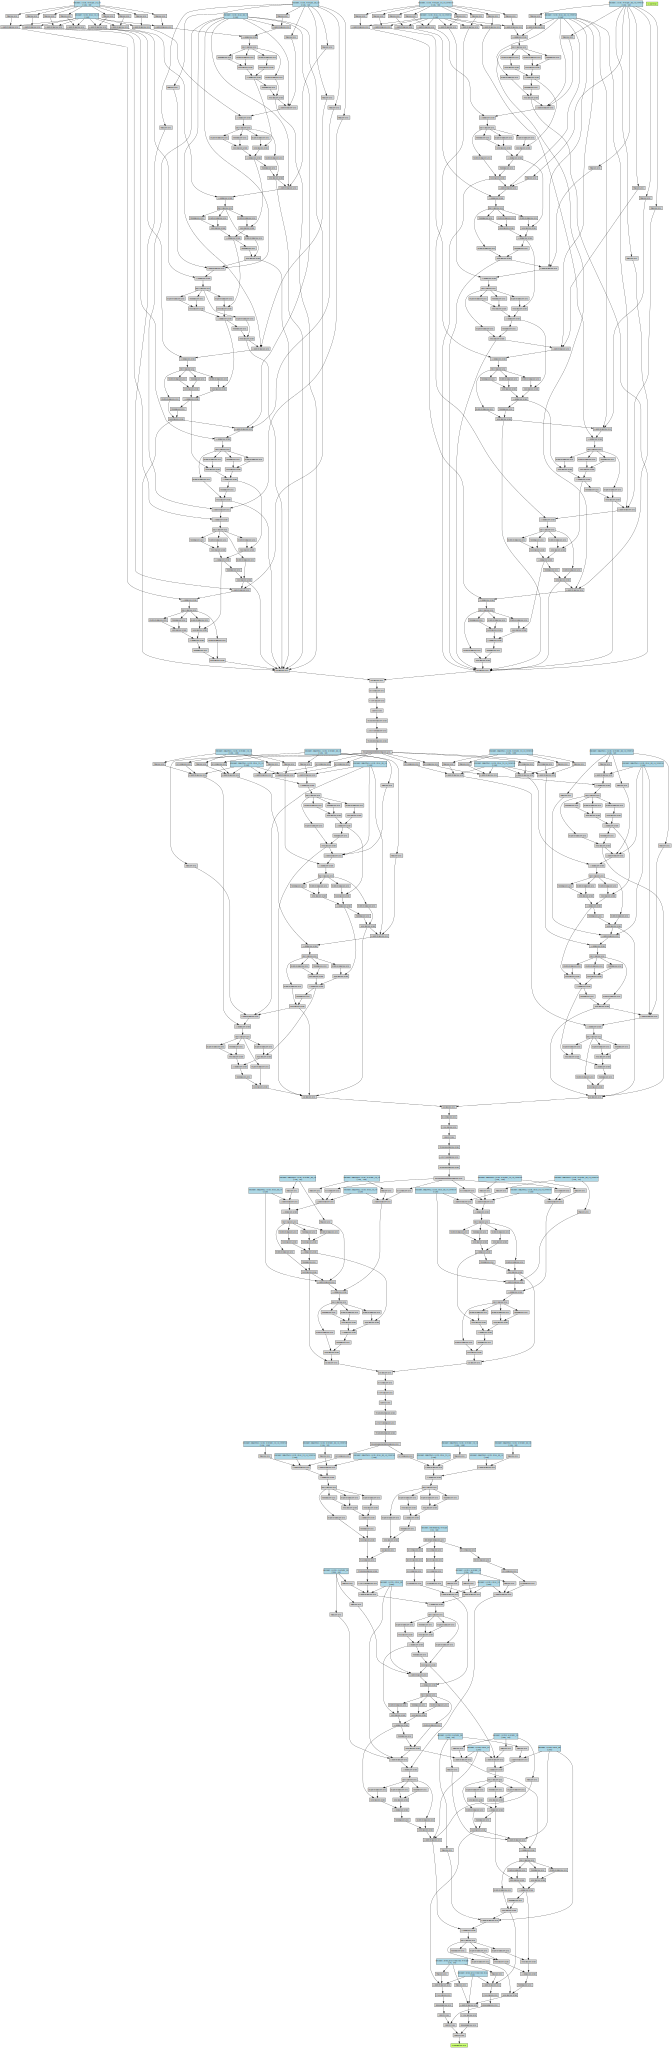

In [12]:
inputs, targets, input_lens, target_lens = next(eval_loader.__iter__())

import matplotlib.pyplot as plt
make_dot(model(inputs[:8,:,:], [8], [targets[0][:8]], [5]), params=dict(model.named_parameters()))
# plt.savefig("figure.png")